In [1]:
# Misc
import os
import time
# import umap
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
# from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression as mutual_inf
from sklearn.feature_selection import mutual_info_classif as mutual_int
# Locals
# import audio.audio_corrupts as corrupt
import audio.audio_model as audiotrain
import audio.audio_data as dataudio
# Torch
import torch
# import torchaudio
# from torch import nn
# from torch.utils.data import DataLoader

get a batch

In [2]:
DATA = "C:\\audio_dataset\\UrbanSound8K"
np.random.seed(0)
file = os.path.join(DATA, "metadata", "UrbanSound8K.csv")
df = pd.read_csv(file)
df['relative_path'] = '\\audio' + '\\fold' + df['fold'].astype(str) + '\\' + df['slice_file_name'].astype(str)
df['corrupt'] = np.random.rand(len(df))
df = df[['relative_path', 'classID', 'corrupt']]
train, val = train_test_split(df, test_size=0.2,random_state=420)
train, val = train.reset_index(drop = True), val.reset_index(drop = True) 

print(val.head())
train_ds = dataudio.SoundDS(train, DATA, transform = True)
val_ds = dataudio.SoundDS(val, DATA, transform = False)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1000, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=1000, shuffle=False)

                     relative_path  classID   corrupt
0     \audio\fold5\17578-5-0-2.wav        5  0.646628
1  \audio\fold1\193698-2-0-114.wav        2  0.479139
2     \audio\fold6\66623-4-0-2.wav        4  0.367986
3      \audio\fold1\9031-3-2-0.wav        3  0.048076
4    \audio\fold7\168846-5-1-4.wav        5  0.095380


In [3]:
for i, batch in enumerate(val_dl):
    data = batch
    break

In [4]:
# data[0].view(data[0].size(0), -1).size()

model

In [5]:
def geti2l(x, layer):
    layer = layer.t()
    n = len(layer)
    values = np.zeros(100) #len(x[0])
    # print(values.shape)
    for i in range(100):
        ewe = mutual_inf(x, layer[i])
        # print(ewe.shape)
        values[i] = np.mean(ewe)
    return values

In [48]:
from concurrent.futures import ThreadPoolExecutor
iters = [1, 25, 50, 75, 100, 125, 150]
model = audiotrain.AudioModel()
outs = []
l2o = []
for i in range(len(iters)):  
    state = torch.load(f'test\\silent\\silent_{iters[i]}.pt')
    model.load_state_dict(state["params"])
    x, y = data
    # print(x.size())
    #
    pca1 = PCA(n_components = 600)
    x1 = torch.from_numpy(np.array(pca1.fit_transform(x)))
    #
    start_time = time.time()
    out = model.encode(x, 2).detach()
    outs.append(out)
    print("Encoding: %s s" % (time.time() - start_time))
    # print(x1.size())
    print(out.size())
    start_time = time.time()
    #
    pca2 = PCA(n_components=100)
    awa = np.array(pca2.fit_transform(out))
    # #
    layer2out = np.array(mutual_int(awa, y))
    # print(layer2out.shape)
    l2o.append(np.mean(layer2out))
    print("l2o: %s s" % (time.time() - start_time))
# print(layer2out)

params_list = [[x1, x1, x1, x1, x1, x1, x1], [outs[0], outs[1], outs[2], outs[3], outs[4], outs[5], outs[6]]]
num_threads = 7
start_time = time.time()
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    i2l = list(executor.map(geti2l, params_list[0], params_list[1]))
print(i2l)
# in2layer = geti2l(x, out)
print("i2l: %s s" % (time.time() - start_time))
# print(in2layer)


Encoding: 0.1867964267730713 s
torch.Size([1000, 512])
l2o: 0.9528303146362305 s
Encoding: 0.21178078651428223 s
torch.Size([1000, 512])
l2o: 0.8847651481628418 s
Encoding: 0.1841275691986084 s
torch.Size([1000, 512])
l2o: 0.8973550796508789 s
Encoding: 0.18966960906982422 s
torch.Size([1000, 512])
l2o: 0.9034810066223145 s
Encoding: 0.17238521575927734 s
torch.Size([1000, 512])
l2o: 0.8900361061096191 s
Encoding: 0.19862079620361328 s
torch.Size([1000, 512])
l2o: 0.9410359859466553 s
Encoding: 0.19351601600646973 s
torch.Size([1000, 512])
l2o: 0.9332966804504395 s
[array([0.01759016, 0.02574173, 0.0254357 , 0.00199913, 0.00235588,
       0.00166446, 0.00068895, 0.00753188, 0.01034767, 0.0028007 ,
       0.        , 0.00179935, 0.        , 0.00055937, 0.        ,
       0.00459522, 0.01420977, 0.00734003, 0.02415682, 0.02399546,
       0.02473969, 0.01544157, 0.0155149 , 0.00726652, 0.        ,
       0.02125252, 0.        , 0.0064923 , 0.0044113 , 0.00046876,
       0.0005258 , 0.0197

In [44]:
np.mean(i2l, axis = 1)

array([0.01373142, 0.01078469, 0.01079425, 0.0103268 , 0.01023586,
       0.00951338, 0.00967236])

In [45]:
np.array(l2o)

array([0.12198222, 0.20360104, 0.22766637, 0.19633947, 0.20568837,
       0.20469475, 0.22472394])

In [50]:
np.save('inf_params_l2_silent.npy', [np.mean(i2l, axis = 1), l2o])

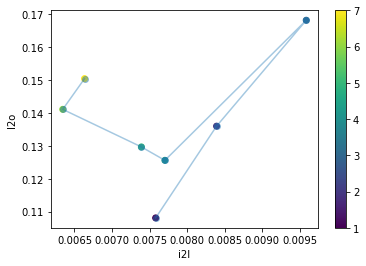

In [49]:
plt.scatter(x = np.mean(i2l, axis = 1), y = np.array(l2o), c = [1, 2, 3, 4, 5, 6, 7])
plt.plot(np.mean(i2l, axis = 1), np.array(l2o), '-o', alpha = 0.4)
plt.xlabel("i2l")
plt.ylabel("l2o")
# plt.title()
plt.colorbar()

In [ ]:
mutual_inf(x, awa[0])

array([0.94153622, 1.05294606, 0.97443943, ..., 0.44916444, 0.47710718,
       0.4499111 ])

In [ ]:
embedding = reducer.fit_transform(awa)
print(embedding)

[[-2.2977848   3.7250195 ]
 [ 7.862205    6.166037  ]
 [ 0.30327573  7.2500834 ]
 [ 4.8211136   7.2082467 ]
 [ 8.741609    5.583044  ]
 [-2.3850393   3.3241477 ]
 [11.355143    3.2084603 ]
 [-2.1905677   4.677459  ]
 [ 2.2915103   8.498811  ]
 [ 2.0085936   8.866209  ]
 [ 5.686702    6.430809  ]
 [ 2.435308    9.338016  ]
 [ 8.348877    5.002508  ]
 [-1.3561319   4.3268456 ]
 [-3.2223773   4.9250236 ]
 [-2.3155515   4.595391  ]
 [10.7807255   2.7273734 ]
 [-0.7338241   4.5357656 ]
 [-0.02644105  6.8101993 ]
 [ 8.398214    4.64194   ]
 [ 8.538699    3.5911515 ]
 [-1.5854307   4.1935735 ]
 [-3.077206    4.585286  ]
 [-2.5547693   4.218985  ]
 [ 7.945829    6.574765  ]
 [-3.1725953   4.8285074 ]
 [ 5.748373    6.1688514 ]
 [ 7.0371504   4.566001  ]
 [ 6.6124983   6.7116947 ]
 [ 1.5131507   8.705071  ]
 [ 2.5083823   9.400297  ]
 [ 7.266891    4.4394274 ]
 [-2.3077698   4.228129  ]
 [ 7.9597178   6.334383  ]
 [-2.6820557   3.0706723 ]
 [ 5.6627235   5.297073  ]
 [ 2.420691    8.487398  ]
 